# Home Assignment No. 2 ( Practice)
To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* To do this part of homework, you have to write **CODE** directly inside specified places inside notebook **CELLS**.

* In some problems you are asked to provide short discussion of the results. In these cases you have to create **MARKDOWN** cell with your comments right after the corresponding code cell.

* For every separate problem you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e. if the reviewer decides to execute all, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest to fix random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include neccessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.

To begin with, let's import the essential (for this assignment) libraries.

# Task 1. MRI T1 image segmentation (10 points)

#### To get maximum points you are to:
 1. attach your working notebook in `hw2` archive **(2 pts)**
 2. attach the trained model with model.state_dict and provide the code for prediction below **(2 pts)**
 3. write an abstract what experiments, validation setups, and fine-tunings brought you to the best DICE score **(2 points)**
 4. segment `100206, 100307, 100408` patients with `DICE score > 0.9` for the defined list of brain regions **(4 points)**
 
 * best result `DICE` **(5 points)**

To get the `norm.nii` images for these three patients you should enter the `docker container` from `Seminar 2` 
https://github.com/adasegroup/NEUROML2020/tree/master/seminar2

And in `freesurfer environement` convert `*.mgz` files to `*.nii` files. You can use the following script:

```   ### path: path to folder with subject to process
      ### basename: root path

      # saving names for normalised and aseg files
      F_NORM="$(find $path/mri/ -name "*norm.mgz")";
      F_PARC="$(find $path/mri/ -name "*aparc+aseg.mgz")";
      
      # echo "$F_NORM file $2/$(basename $1)_$(basename $path)_norm.nii.gz" 
      # echo "$F_PARC file $2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz"

      # converting files to needed format
      mri_convert -it "mgz" -ot "nii" "$F_NORM" "$2/$(basename $1)_$(basename $path)_norm.nii.gz";
      mri_convert -it "mgz" -ot "nii" "$F_PARC" "$2/$(basename $1)_$(basename $path)_aparc+aseg.nii.gz";
```        

See documentation: https://surfer.nmr.mgh.harvard.edu/fswiki/mri_convert

If you facing any troubles, you can find converted files in `fs_norm`.

<img src="assets/2020-09-18_22-40-04.png" width="600" height="400">

You have the ground truth to compare your result in `/fs_segmentation/`. Please do not cheat with it: either pretraining model or in any other way using the ground truth for your prediction. The best average `DICE score` across three images will be awarded **5 extra points.**

#### Part 2: provide the code for prediction below (2 pts)

In [ ]:
### BEGIN Solution

# >>> your solution here <<<

### END Solution

#### Part 3: write an abstract what experiments, validation setups, and fine-tunings brought you to the best DICE score **(2 points)**

#### Several senteces here...

#### Part 4: segment 100206, 100307, 100408 patients with DICE score > 0.9 for the defined list of brain regions (4 points)

*Please be sure, you we training on the same labels `LIST_ASEG`*:

In [20]:
import numpy as np

LIST_ASEG =  [ 8,  10,  11,  12,  13,  16, 17,  18,  26,  47, 49,   50, 
  51,   52,   53,  54,   58,  85,  251,  252,  253,  254,  255] # gray matter segmentation labels

def get_dice_score(output, target, SPATIAL_DIMENSIONS = (2, 3, 4), epsilon=1e-9):
    p0 = output
    g0 = target
    p1 = 1 - p0
    g1 = 1 - g0
    tp = (p0 * g0).sum()
    fp = (p0 * g1).sum()
    fn = (p1 * g0).sum()
    num = 2 * tp
    denom = 2 * tp + fp + fn + epsilon
    dice_score = num / denom
    return dice_score

def prepare_aseg(targets):
    """
    The function binarises the data  with the LABEL list.
    """
    targets[0][0][(np.isin(targets[0][0], LIST_ASEG))] = 1
    targets[targets >= 1000] = 1
    targets[targets != 1] = 0 
    return targets

import matplotlib.pyplot as plt
import torch
import numpy as np
import nibabel

def plot_central_cuts(img, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.numpy()
        if (len(img.shape) > 3):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2, :, :])
    axes[1].imshow(img[ :, img.shape[1] // 2, :])
    axes[2].imshow(img[ :, :, img.shape[2] // 2])
    
    plt.show()
    
def plot_predicted(img, seg, delta = 0, title=""):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    """
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()
        if (len(img.shape) == 5):
            img = img[0,0,:,:,:]
        elif (len(img.shape) == 4):
            img = img[0,:,:,:]
                
    elif isinstance(img, nibabel.nifti1.Nifti1Image):    
        img = img.get_fdata()
        
    if isinstance(seg, torch.Tensor):
        seg= seg[0].cpu().numpy().astype(np.uint8)
   
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 4, 4))
    axes[0].imshow(img[ img.shape[0] // 2 + delta, :, :])
    axes[1].imshow(seg[ seg.shape[0] // 2 + delta, :, :])
    intersect = img[ img.shape[0] // 2 + delta, :, :] + seg[ seg.shape[0] // 2 + delta, :, :]*100
    axes[2].imshow(intersect, cmap='gray')
    
    plt.show()

##### Predicting subject `100206`:

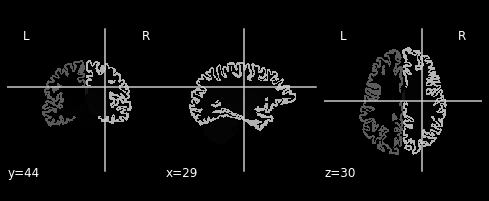

In [21]:
import nilearn
from nilearn import plotting
%matplotlib inline

# visualising normalised image
img = nilearn.image.load_img('fs_segmentation/HCP_T1_fs6_100206_aparc+aseg.nii.gz')
plotting.plot_anat(img);

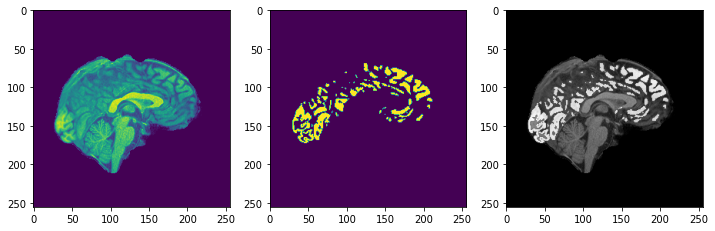

DICE for the `100260` prediction 0.9999999999999992


In [24]:
# preparing needed segmentation
sub_100206 = prepare_aseg(np.asanyarray(img.dataobj))

# plotting ground truth
plot_predicted(np.asanyarray(nilearn.image.load_img('fs_norm/HCP_T1_fs6_100206_norm.nii.gz').dataobj), sub_100206)

# plotting your prediction
plot_predicted(<YOUR CODE>, sub_100206)

# Calculating DICE
print( 'DICE for the `100206` prediction', get_dice_score(<YOUR CODE>, sub_100206))
assert(get_dice_score(<YOUR CODE>, sub_100206) > 0.9)

##### Predicting subject `100307`:

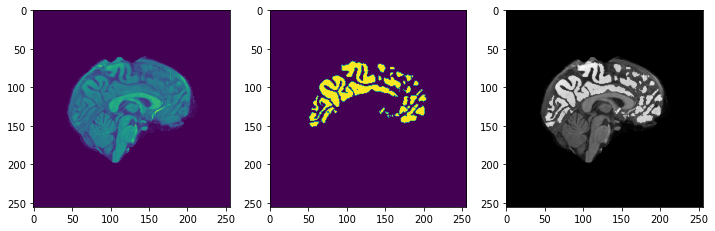

DICE for the `100307` prediction 0.999999999999999


In [29]:
# preparing needed segmentation
img = nilearn.image.load_img('fs_segmentation/HCP_T1_fs6_100307_aparc+aseg.nii.gz')
sub_100307 = prepare_aseg(np.asanyarray(img.dataobj))

# plotting ground truth
plot_predicted(np.asanyarray(nilearn.image.load_img('fs_norm/HCP_T1_fs6_100307_norm.nii.gz').dataobj), sub_100307)

# plotting your prediction
plot_predicted(<YOUR CODE>, sub_100307)

# Calculating DICE
print( 'DICE for the `100307` prediction', get_dice_score(<YOUR CODE>, sub_100307))
assert(get_dice_score(<YOUR CODE>, sub_100307) > 0.9)

##### Predicting subject `100408`:

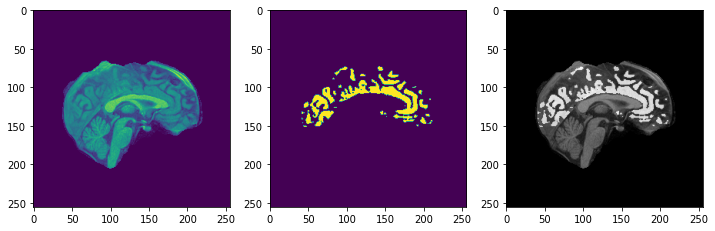

DICE for the `100408` prediction 0.9999999999999991


In [30]:
# preparing needed segmentation
img = nilearn.image.load_img('fs_segmentation/HCP_T1_fs6_100408_aparc+aseg.nii.gz')
sub_100408 = prepare_aseg(np.asanyarray(img.dataobj))

# plotting ground truth
plot_predicted(np.asanyarray(nilearn.image.load_img('fs_norm/HCP_T1_fs6_100408_norm.nii.gz').dataobj), sub_100408)

# plotting your prediction
plot_predicted(<YOUR CODE>, sub_100408)

# Calculating DICE
print( 'DICE for the `100408` prediction', get_dice_score(<YOUR CODE>, sub_100408))
assert(get_dice_score(<YOUR CODE>, sub_100408) > 0.9)

# Task 2. Comet ML panel (10 points)

Attach here a link to your public experiment in `Comet ML`:

PS this homework is intended not on beating the seminar `DICE score`, rather or conducting the small and good experiment with its annotation. That is why, the `Comet ML` part is scored the most, so please put more effort into your results representation. The best pannel will be graded with **5 extra points.**